In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/RiceLeafs/train"

BrownSpot  Healthy  Hispa  LeafBlast


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array , array_to_img
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten , Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

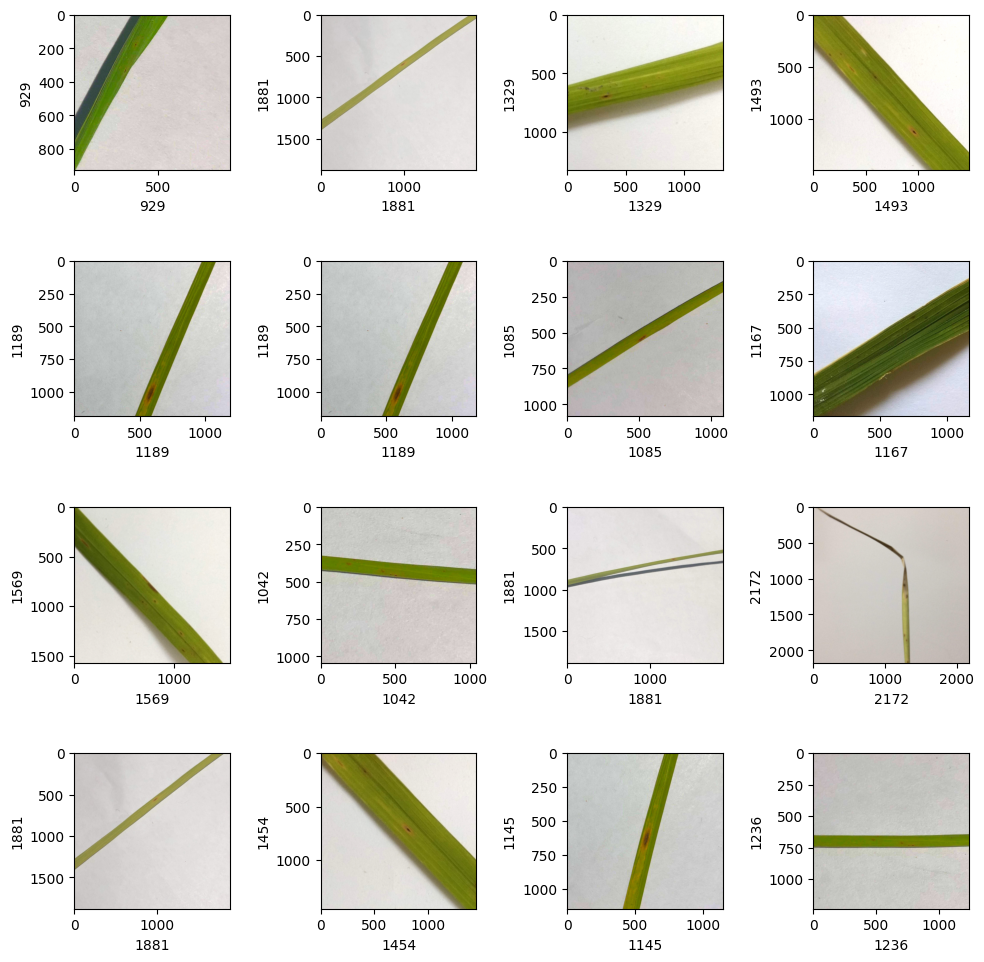

In [4]:
plt.figure(figsize=(10, 10))
path = "/content/drive/MyDrive/RiceLeafs/train/BrownSpot"
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[1], fontsize = 10)


In [5]:
def convert_image_to_array(image_dir):
  try:
      image = cv2.imread(image_dir)
      if image is not None :
         image = cv2.resize(image, (299, 299))
         return img_to_array(image)
      else :
        return np.array([])
  except Exception as e:
        print(f"Error : {e}")
        return None


In [6]:
import os

dir = "/content/drive/MyDrive/RiceLeafs/train"
image_list, label_list = [], []
all_labels = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
binary_labels = [0, 1, 2, 3]
temp = -1

for directory in all_labels:
    plant_image_list = os.listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])


In [7]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

3    623
2    452
1    397
0     56
dtype: int64

In [8]:
image_list[0].shape

(299, 299, 3)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)


In [10]:
x_train = np.array(x_train, dtype=np.float16)/255.0
x_test = np.array(x_test, dtype=np.float16)/255.0
x_train = x_train.reshape(-1, 299, 299, 3)
x_test = x_test.reshape(-1, 299, 299, 3)



In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(all_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test)
)


Epoch 1/10
39/39 [==============================] - 84s 648ms/step - loss: 1.3706 - accuracy: 0.4067 - val_loss: 113.6415 - val_accuracy: 0.4281
Epoch 2/10
39/39 [==============================] - 17s 433ms/step - loss: 1.0635 - accuracy: 0.4697 - val_loss: 6.7276 - val_accuracy: 0.4673
Epoch 3/10
39/39 [==============================] - 17s 435ms/step - loss: 1.0362 - accuracy: 0.5123 - val_loss: 24.6443 - val_accuracy: 0.4281
Epoch 4/10
39/39 [==============================] - 17s 439ms/step - loss: 0.9710 - accuracy: 0.5663 - val_loss: 2.5648 - val_accuracy: 0.4216
Epoch 5/10
39/39 [==============================] - 17s 444ms/step - loss: 0.8741 - accuracy: 0.5974 - val_loss: 6.7763 - val_accuracy: 0.4281
Epoch 6/10
39/39 [==============================] - 17s 447ms/step - loss: 0.7677 - accuracy: 0.6489 - val_loss: 1.8853 - val_accuracy: 0.4804
Epoch 7/10
39/39 [==============================] - 17s 447ms/step - loss: 0.6925 - accuracy: 0.6899 - val_loss: 4.4177 - val_accuracy: 0.4

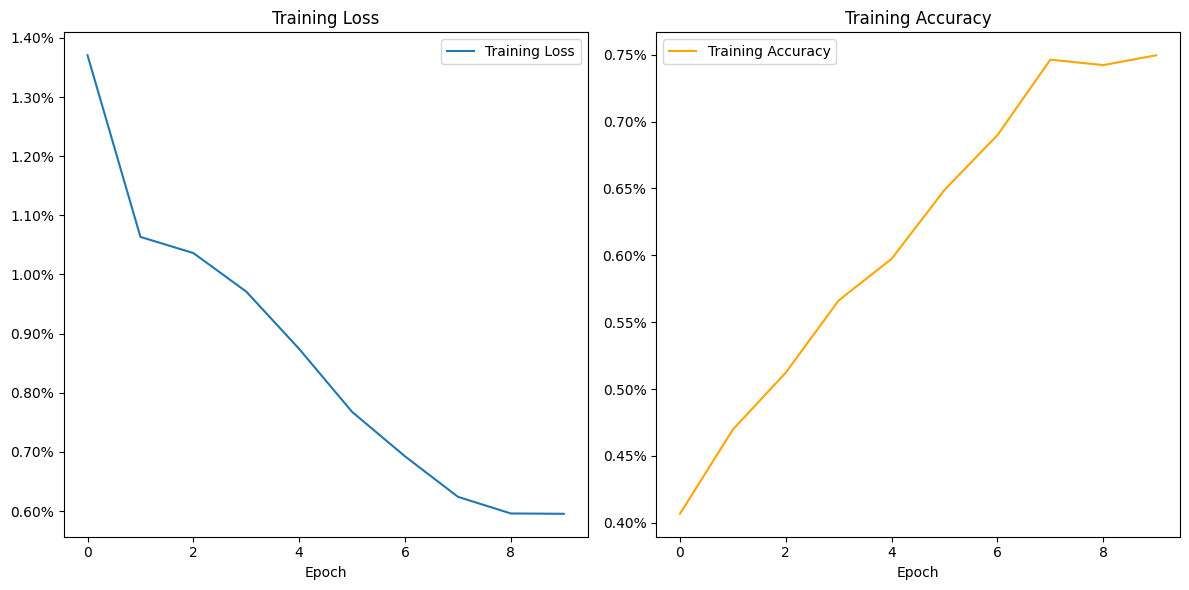

Overall Loss: 0.5953
Overall Accuracy: 0.7496


In [16]:
# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

plt.tight_layout()
plt.show()

# Print overall accuracy and loss
final_loss = history.history['loss'][-1]
final_accuracy = model.history.history['accuracy'][-1]

print(f"Overall Loss: {final_loss:.4f}")
print(f"Overall Accuracy: {final_accuracy:.4f}")






In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/RiceLeafs/RiceLeafs/train/Healthy/IMG_20190419_124221.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image by dividing by 255.0

# Make predictions
predictions = model.predict(img_array)
predicted_label = all_labels[np.argmax(predictions)]
print("Predicted label:", predicted_label)


1/1 [==============================] - 3s 3s/step
Predicted label: LeafBlast


In [18]:
y_pred = model.predict(x_test)

10/10 [==============================] - 1s 114ms/step


In [19]:
print("original Label: ", all_labels[np.argmax(y_test[12])])
print("predicted Label: ", all_labels[np.argmax(y_pred[15])])
print(y_pred[11])


original Label:  LeafBlast
predicted Label:  LeafBlast
[2.7295417e-04 7.8227639e-02 8.9800847e-01 2.3490973e-02]


In [20]:
correct_predictions = 0

for i in range(100):
    true_label = all_labels[np.argmax(y_test[i])]
    predicted_label = all_labels[np.argmax(y_pred[i])]

    print(true_label, "-", predicted_label)

    if true_label == predicted_label:
        correct_predictions += 1

print("Number of correct predictions:", correct_predictions)


LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
BrownSpot - LeafBlast
Hispa - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - LeafBlast
Hispa - Hispa
Hispa - Hispa
Hispa - Hispa
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Hispa - LeafBlast
Hispa - Hispa
Healthy - Hispa
Healthy - Hispa
LeafBlast - LeafBlast
Healthy - LeafBlast
LeafBlast - LeafBlast
Hispa - LeafBlast
LeafBlast - LeafBlast
BrownSpot - LeafBlast
BrownSpot - LeafBlast
LeafBlast - LeafBlast
LeafBlast - LeafBlast
Healthy - LeafBlast
Hispa - Hispa
Healthy - Hispa
Hispa - LeafBlast
Healthy - Hispa
LeafBl